# IMPORTS

In [ ]:
# Clone the Git repository and navigate to the project directory
!git clone https://github.com/DanteMillerDS/MPA_Predictor.git
%cd MPA_Predictor

# Install required packages
!pip install xgboost
!pip install pytorch-tabnet
!pip install torch

# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.io
import torch
import uuid
from IPython.display import display
from sklearn.preprocessing import PowerTransformer, QuantileTransformer
import torch
import xgboost as xgb
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
import tensorflow as tf
from pytorch_tabnet.tab_model import TabNetRegressor
import keras
from sklearn.model_selection import KFold


# Set random seeds for reproducibility
np.random.seed(1000)
tf.random.set_seed(1000)

# PREPROCESSING

In [ ]:
# Read files
file_paths = dict()
file_paths[0] = ["data/s11_dB_freq.txt"]

# Process files
def process_file(file_path):
    datasets = []
    with open(file_path, 'r') as file:
        current_dataset = []
        for line in file:
            if line.startswith("#Parameters"):
                if current_dataset:
                    datasets.append(current_dataset)
                    current_dataset = []
                params_str = line[line.index("{") + 1:line.index("}")]
                params = dict(param.split('=') for param in params_str.split(';'))
                current_dataset.append(params)
            elif line.startswith("#"):
                continue
            else:
                data = line.strip().split('\t')
                current_dataset.append(data)
        if current_dataset:
            datasets.append(current_dataset)
    data = []
    for dataset in datasets:
        permittivity_values = dataset[0]
        df_data = dataset[1:]
        s_parameter_name = file_path.split("_parameter_data_for_")[0]
        df = pd.DataFrame(df_data, columns=["Frequency", f"{s_parameter_name}"])
        df["ID"] = str(uuid.uuid4())[:8]
        for key, value in permittivity_values.items():
            df[key.replace(" ", "")] = value
        data.append(df)
    return data
all_combined_data = []
for index in file_paths:
    for file in file_paths[index]:
        combined_data = process_file(file)
        combined_data = pd.concat(combined_data, ignore_index=True)
        all_combined_data.append(combined_data)
array = []
group_size = 4
for i in range(0, len(all_combined_data), group_size):
    combined_dataframe = pd.concat(all_combined_data[i:i+group_size], axis=1)
    combined_dataframe.reset_index(drop=True, inplace=True)
    array.append(combined_dataframe)
training_dataframe = pd.concat(array, axis=0)
training_dataframe.reset_index(drop=True, inplace=True)
training_dataframe = training_dataframe.loc[:, ~training_dataframe.columns.duplicated()]

In [ ]:
# Print columns
print(training_dataframe.columns)

Index(['Frequency', 'data/s11_dB_freq.txt', 'ID', 'rprobe', 'rin', 'er22',
       'er2', 'cl', 'r0', 'w', 'L', 't', 'h', 'wy', 'wx', 'er11', 'er1'],
      dtype='object')


In [ ]:
# Grab specific columns
needed_columns = ["Frequency","data/s11_dB_freq.txt","h","t","er11","er1","w","L"]
training_dataframe = training_dataframe[needed_columns]

In [ ]:
# Define variable names
training_dataframe.columns = ["Frequency","Input_Impedance","Substrate_Thickness","Patch_Thickness","Permittivity_Imaginary","Permittivity_Real","Width","Length"]

In [ ]:
# Print variable names
training_dataframe.columns

Index(['Frequency', 'Input_Impedance', 'Substrate_Thickness',
       'Patch_Thickness', 'Permittivity_Imaginary', 'Permittivity_Real',
       'Width', 'Length'],
      dtype='object')

In [ ]:
# Drop na and applying numeric
training_dataframe.dropna(inplace=True)
columns = training_dataframe.columns[1:]
training_dataframe[columns] = training_dataframe[columns].apply(pd.to_numeric)

In [ ]:
# Describe dataframe
training_dataframe.describe()

,Input_Impedance,Substrate_Thickness,Patch_Thickness,Permittivity_Imaginary,Permittivity_Real,Width,Length
count,100100.000000,1.001000e+05,1.001000e+05,1.001000e+05,1.001000e+05,100100.000000,100100.000000
mean,-3.252633,1.600000e+00,2.000000e-01,1.000000e-02,2.550000e+00,28.759751,46.015602
std,4.162713,2.220457e-16,2.775571e-17,1.734732e-18,4.440914e-16,13.298825,21.278120
min,-29.213769,1.600000e+00,2.000000e-01,1.000000e-02,2.550000e+00,5.535593,8.856949
25%,-4.395586,1.600000e+00,2.000000e-01,1.000000e-02,2.550000e+00,16.560724,26.497158
50%,-1.654782,1.600000e+00,2.000000e-01,1.000000e-02,2.550000e+00,29.681131,47.489809
75%,-0.417934,1.600000e+00,2.000000e-01,1.000000e-02,2.550000e+00,40.209226,64.334762
max,0.140660,1.600000e+00,2.000000e-01,1.000000e-02,2.550000e+00,48.676675,77.882680


In [ ]:
# Print dataframe head
training_dataframe.head(5)

,Frequency,Input_Impedance,Substrate_Thickness,Patch_Thickness,Permittivity_Imaginary,Permittivity_Real,Width,Length
0,1.0000000000000,-0.163918,1.6,0.2,0.01,2.55,41.662566,66.660105
1,1.0089999437332,-0.131358,1.6,0.2,0.01,2.55,41.662566,66.660105
2,1.0180000066757,-0.068440,1.6,0.2,0.01,2.55,41.662566,66.660105
3,1.0269999504089,-0.013418,1.6,0.2,0.01,2.55,41.662566,66.660105
4,1.0360000133514,-0.000152,1.6,0.2,0.01,2.55,41.662566,66.660105


In [ ]:
# Find lowest impudance value in each set
lowest_impedance_rows = pd.DataFrame(columns=training_dataframe.columns)
for i in range(0,len(training_dataframe),1001):
  subset = training_dataframe[i:i+1001]
  min_impedance_row = subset[subset['Input_Impedance'] == subset['Input_Impedance'].min()]
  lowest_impedance_rows = pd.concat([lowest_impedance_rows, min_impedance_row])

In [ ]:
# Show new dataframe
lowest_impedance_rows

,Frequency,Input_Impedance,Substrate_Thickness,Patch_Thickness,Permittivity_Imaginary,Permittivity_Real,Width,Length
385,4.4650001525879,-20.224921,1.6,0.2,0.01,2.55,41.662566,66.660105
1344,4.0869998931885,-19.536557,1.6,0.2,0.01,2.55,45.760637,73.217019
2983,9.8290004730225,-24.501126,1.6,0.2,0.01,2.55,10.714407,17.143051
3343,4.0599999427795,-19.490123,1.6,0.2,0.01,2.55,46.101914,73.763062
4503,5.4910001754761,-23.453824,1.6,0.2,0.01,2.55,33.456166,53.529866
5514,5.5809998512268,-11.790161,1.6,0.2,0.01,2.55,9.389318,15.022909
6590,6.2560000419617,-26.042706,1.6,0.2,0.01,2.55,17.532420,28.051872
7578,6.1389999389648,-26.357643,1.6,0.2,0.01,2.55,29.609668,47.375469
8297,3.6010000705719,-20.192231,1.6,0.2,0.01,2.55,48.087808,76.940492
9295,3.5739998817444,-20.878927,1.6,0.2,0.01,2.55,48.419984,77.471975


In [ ]:
# Set training dataframe equaled to lowest imepedance dataframe
training_dataframe = lowest_impedance_rows

# DATA VISUALIZATION

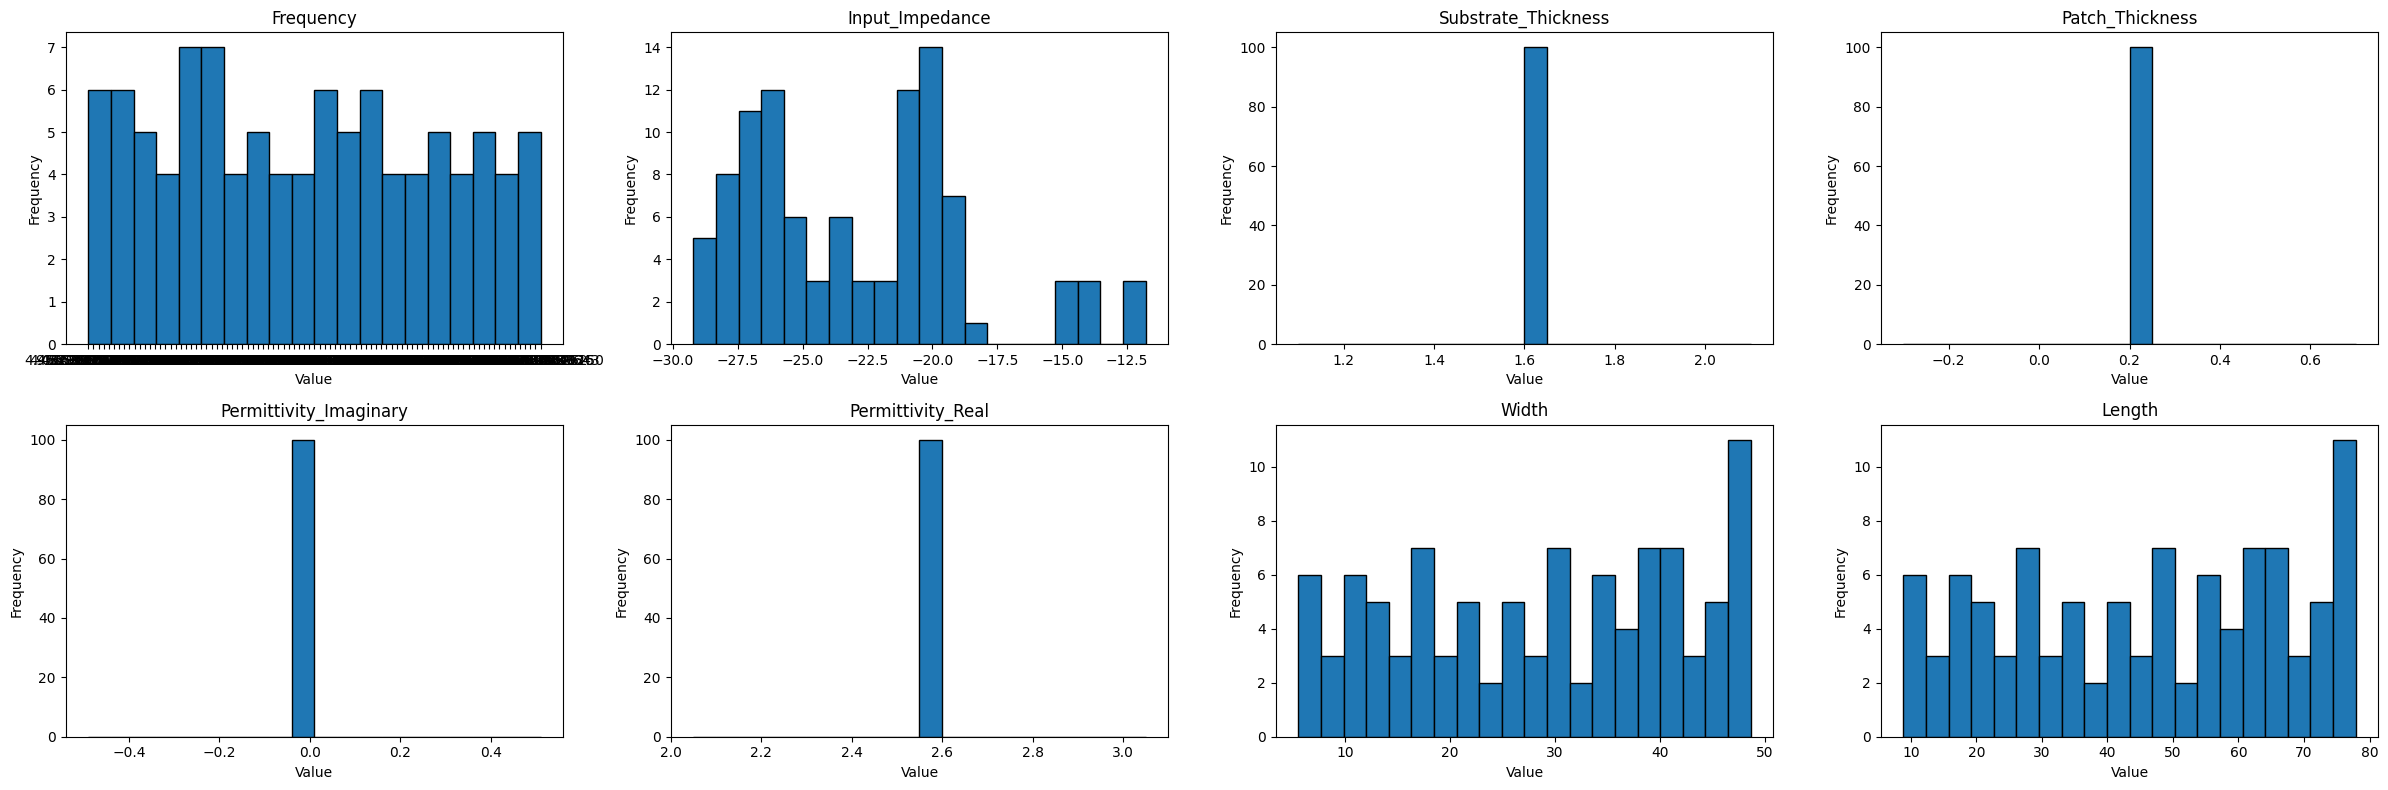

In [ ]:
# Plot columns
plt.figure(figsize=(24, 8))
for i, column in enumerate(training_dataframe.columns):
    plt.subplot(2,4 , i+1)
    plt.hist(training_dataframe[column], bins=20, edgecolor='black')
    plt.title(column)
    plt.xlabel('Value')
    plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

In [ ]:
# Grabbing column means
columns = ["Input_Impedance","Width","Length"]
training_mean_predicted_values = training_dataframe.groupby('Frequency')[columns].mean()

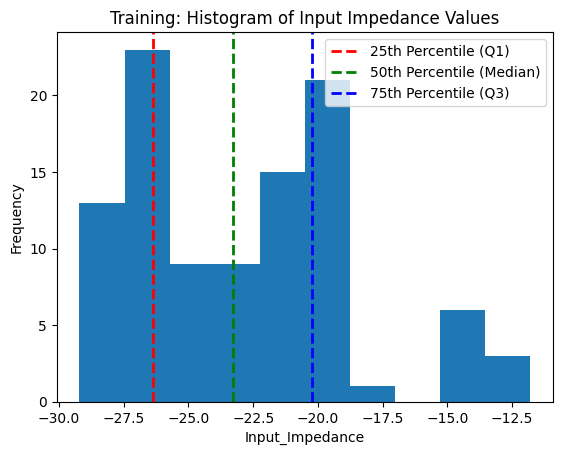

In [ ]:
# Showing mean for the input impedance
q25 = np.percentile(training_dataframe["Input_Impedance"], 25)
q50 = np.percentile(training_dataframe["Input_Impedance"], 50)
q75 = np.percentile(training_dataframe["Input_Impedance"], 75)
plt.hist(training_dataframe["Input_Impedance"])
plt.xlabel("Input_Impedance")
plt.ylabel("Frequency")
plt.title("Training: Histogram of Input Impedance Values")
plt.axvline(q25, color='red', linestyle='dashed', linewidth=2, label='25th Percentile (Q1)')
plt.axvline(q50, color='green', linestyle='dashed', linewidth=2, label='50th Percentile (Median)')
plt.axvline(q75, color='blue', linestyle='dashed', linewidth=2, label='75th Percentile (Q3)')
plt.legend()
plt.show()

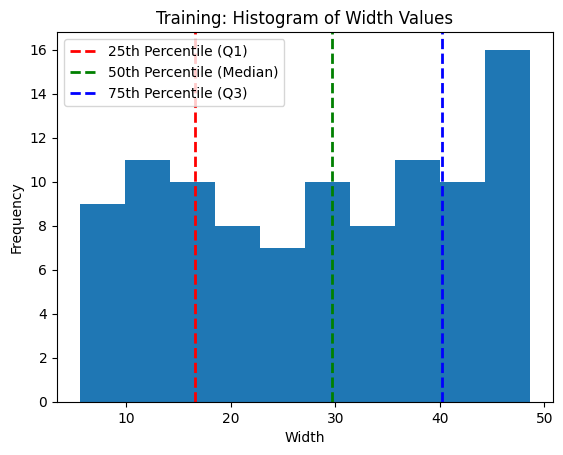

In [ ]:
# Showing mean for the width
q25 = np.percentile(training_dataframe["Width"], 25)
q50 = np.percentile(training_dataframe["Width"], 50)
q75 = np.percentile(training_dataframe["Width"], 75)
plt.hist(training_dataframe["Width"])
plt.xlabel("Width")
plt.ylabel("Frequency")
plt.title("Training: Histogram of Width Values")
plt.axvline(q25, color='red', linestyle='dashed', linewidth=2, label='25th Percentile (Q1)')
plt.axvline(q50, color='green', linestyle='dashed', linewidth=2, label='50th Percentile (Median)')
plt.axvline(q75, color='blue', linestyle='dashed', linewidth=2, label='75th Percentile (Q3)')
plt.legend()
plt.show()

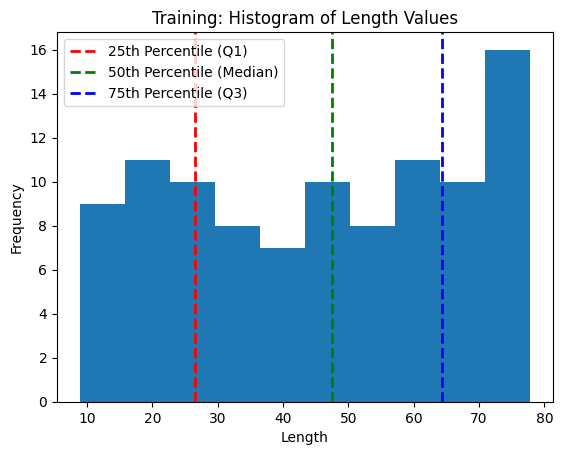

In [ ]:
# Showing mean for the length
q25 = np.percentile(training_dataframe["Length"], 25)
q50 = np.percentile(training_dataframe["Length"], 50)
q75 = np.percentile(training_dataframe["Length"], 75)
plt.hist(training_dataframe["Length"])
plt.xlabel("Length")
plt.ylabel("Frequency")
plt.title("Training: Histogram of Length Values")
plt.axvline(q25, color='red', linestyle='dashed', linewidth=2, label='25th Percentile (Q1)')
plt.axvline(q50, color='green', linestyle='dashed', linewidth=2, label='50th Percentile (Median)')
plt.axvline(q75, color='blue', linestyle='dashed', linewidth=2, label='75th Percentile (Q3)')
plt.legend()
plt.show()

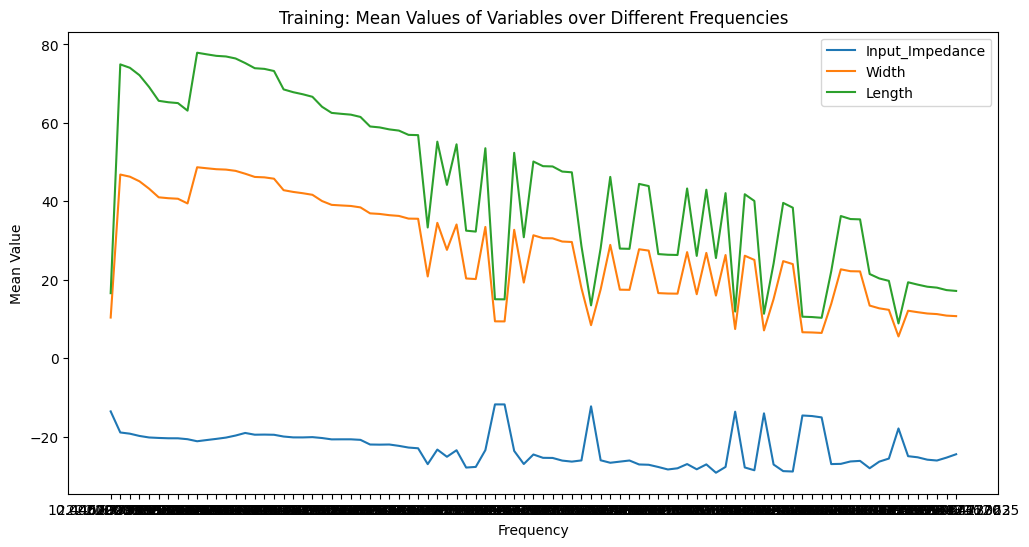

In [ ]:
# Plot mean over frequencies
plt.figure(figsize=(12, 6))
for col in training_mean_predicted_values.columns:
    plt.plot(training_mean_predicted_values.index, training_mean_predicted_values[col], label=col)
plt.xlabel('Frequency')
plt.ylabel('Mean Value')
plt.title('Training: Mean Values of Variables over Different Frequencies')
plt.legend()
plt.show()

# DATA MANIPULATION

In [ ]:
# Divide by 100
training_dataframe["Substrate_Thickness"] /= 100
training_dataframe["Permittivity_Real"] /= 100

In [ ]:
# Power transform
bc = PowerTransformer()
bc.fit(training_dataframe[["Frequency"]])
training_dataframe[training_dataframe[["Frequency"]].columns] = bc.transform(training_dataframe[["Frequency"]])
bc = PowerTransformer()
bc.fit(training_dataframe[["Input_Impedance","Width","Length"]])
training_dataframe[training_dataframe[["Input_Impedance","Width","Length"]].columns] = bc.transform(training_dataframe[["Input_Impedance","Width","Length"]])

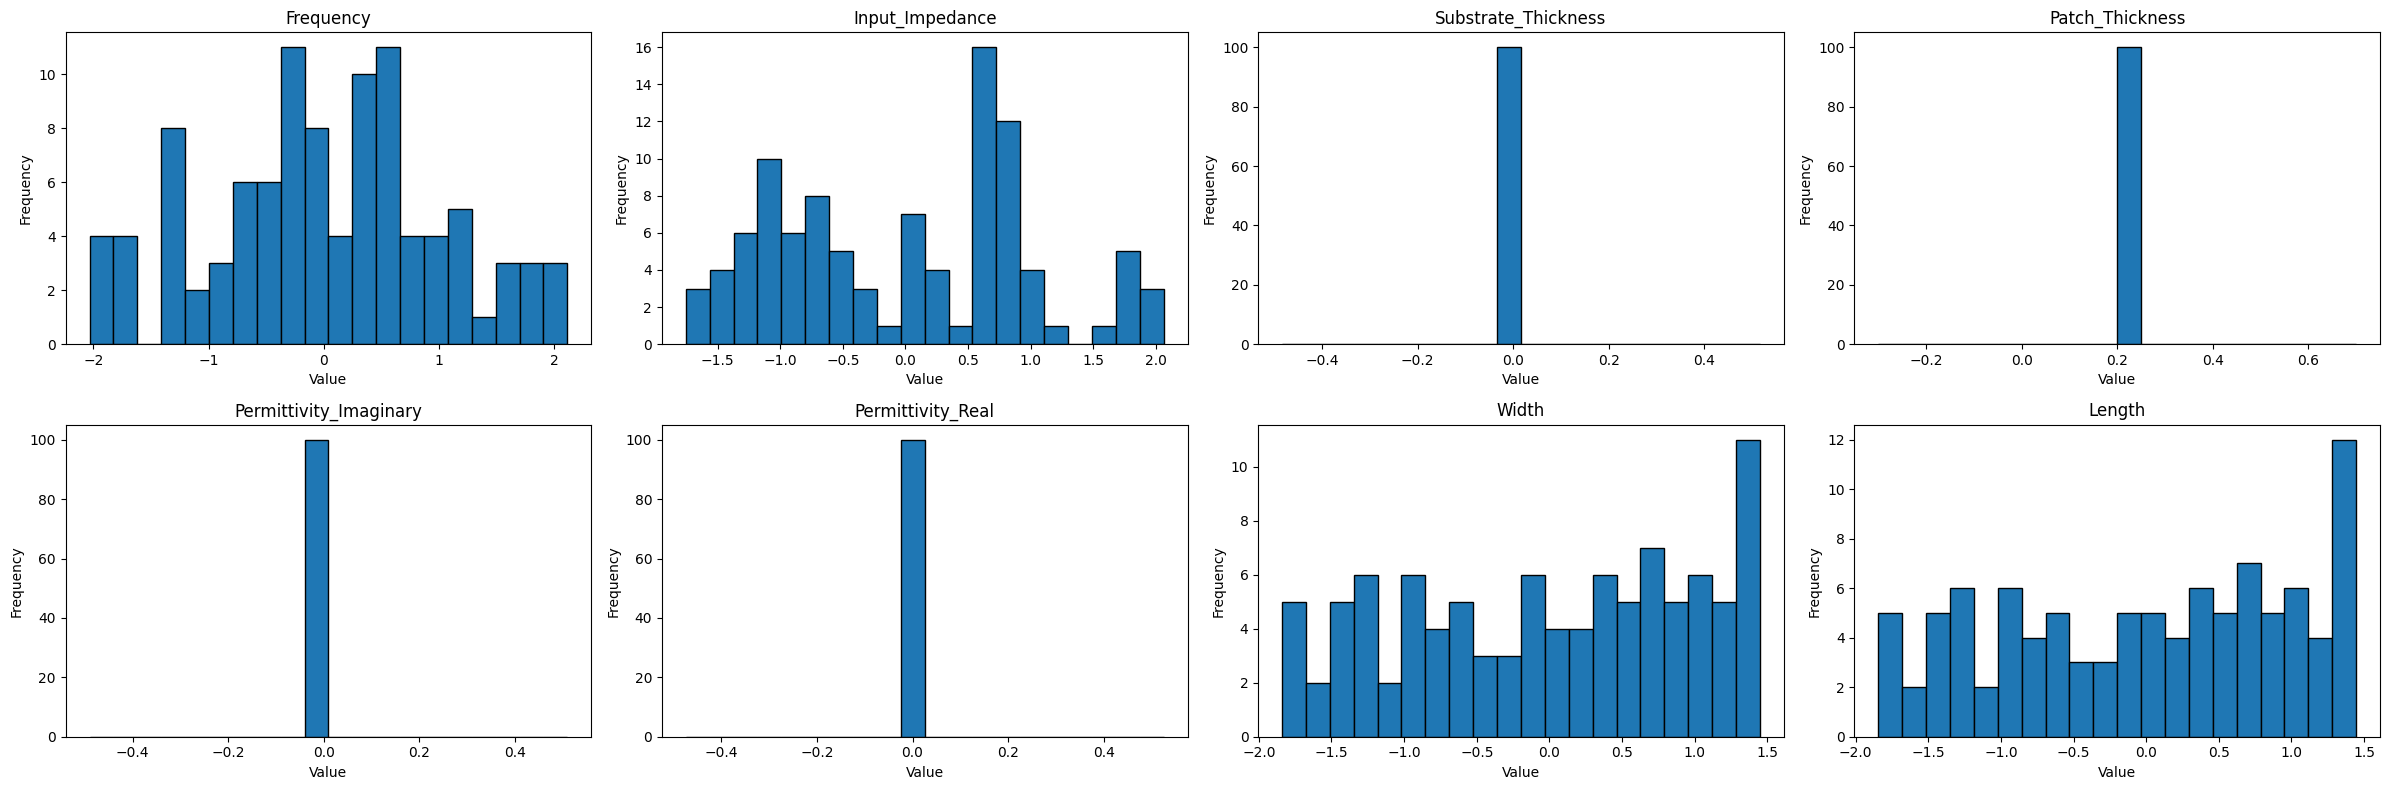

In [ ]:
# Plot
plt.figure(figsize=(24, 8))
for i, column in enumerate(training_dataframe.columns):
    plt.subplot(2,4 , i+1)
    plt.hist(training_dataframe[column], bins=20, edgecolor='black')
    plt.title(column)
    plt.xlabel('Value')
    plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

# MODELS

In [ ]:
# Hyperparameters
LR = 0.001
L2 = 0.0001
WD = 0.00001

In [ ]:
# Column names
columns = []
for column in training_dataframe.columns:
    if column not in ["Width","Length","Input_Impedance"]:
        columns.append(column)
columns

['Frequency',
 'Substrate_Thickness',
 'Patch_Thickness',
 'Permittivity_Imaginary',
 'Permittivity_Real']

In [ ]:
# K fold
X_train = training_dataframe[columns].values
y_train = training_dataframe[["Width","Length","Input_Impedance"]].values
selected_indices = np.random.permutation(len(training_dataframe))
X_selected = X_train[selected_indices]
y_selected = y_train[selected_indices]
train_indices, test_indices = train_test_split(selected_indices, test_size=0.1, random_state=100)
kf = KFold(n_splits=5, shuffle=True, random_state=100)
X_train_indices = dict()
X_val_indices = dict()
X_test_indices = dict()
for index, (train_indices, val_indices) in enumerate(kf.split(train_indices)):
    X_train_indices[index] = train_indices
    X_val_indices[index] = val_indices
    X_test_indices[index] = test_indices

In [ ]:
# Showing number of observations
num_obs_train = len(X_selected[train_indices])
num_obs_val = len(X_selected[val_indices])
num_obs_test = len(X_selected[test_indices])
total_obs = num_obs_train + num_obs_val + num_obs_test
data = {'Dataset': ['Training', 'Validation', 'Test', 'Total'],
            'Number of Observations': [num_obs_train, num_obs_val, num_obs_test, total_obs]}
observations_table = pd.DataFrame(data)
print(observations_table)

      Dataset  Number of Observations
0    Training                      72
1  Validation                      18
2        Test                      10
3       Total                     100


In [ ]:
# Train models
def train_models(X_train,y_train,X_val,y_val):

    def rmse_loss(y_true, y_pred):
      squared_error = tf.square(y_true - y_pred)
      mean_squared_error = tf.reduce_mean(squared_error)
      root_mean_squared_error = tf.sqrt(mean_squared_error)
      return root_mean_squared_error

    nn_model = keras.Sequential([
        keras.layers.Dense(128, activation='relu', input_shape=(X_train.shape[1],),kernel_initializer='he_uniform', kernel_regularizer=tf.keras.regularizers.l2(L2)),
        keras.layers.Dense(64, activation='relu', kernel_initializer='he_uniform',kernel_regularizer=tf.keras.regularizers.l2(L2)),
        keras.layers.Dense(32, activation='relu', kernel_initializer='he_uniform',kernel_regularizer=tf.keras.regularizers.l2(L2)),
        keras.layers.Dense(16, activation='relu', kernel_initializer='he_uniform',kernel_regularizer=tf.keras.regularizers.l2(L2)),
        keras.layers.Dense(y_train.shape[1], activation='linear')
    ])


    nn_model.compile(optimizer=tf.optimizers.Adam(learning_rate=L2,weight_decay=WD),
                  loss=[rmse_loss],
                  metrics=[tf.metrics.MeanAbsoluteError(), tf.metrics.MeanSquaredError()])
    nn_model.summary()
    history = nn_model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100,shuffle=True)
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['mean_absolute_error'])
    plt.plot(history.history['val_mean_absolute_error'])
    plt.title('FNN: Mean Absolute Error')
    plt.xlabel('Epoch')
    plt.ylabel('Mean Absolute Error')
    plt.legend(['Train', 'Validation'])
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('FNN: Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(['Train', 'Validation'])
    plt.tight_layout()
    plt.show()

    xgb_model = xgb.XGBRegressor(n_jobs=-1,device="gpu",n_estimators=250,eval_metric=mean_absolute_error,verbosity=3,max_depth=6)
    xgb_model.fit(X_train, y_train)

    X_train_tensor = torch.tensor(X_train , dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
    X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
    y_val_tensor = torch.tensor(y_val, dtype=torch.float32)
    tabnet_model = TabNetRegressor(device_name = "cuda")
    tabnet_model.fit(
        X_train, y_train,
        eval_set=[(X_val, y_val)],
        eval_metric=['mae'],
        max_epochs=75,
        batch_size = 5
    )
    return nn_model, xgb_model, tabnet_model

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               768       
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dense_2 (Dense)             (None, 32)                2080      
                                                                 
 dense_3 (Dense)             (None, 16)                528       
                                                                 
 dense_4 (Dense)             (None, 3)                 51        
                                                                 
Total params: 11683 (45.64 KB)
Trainable params: 11683 (45.64 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/100
3/3 [===

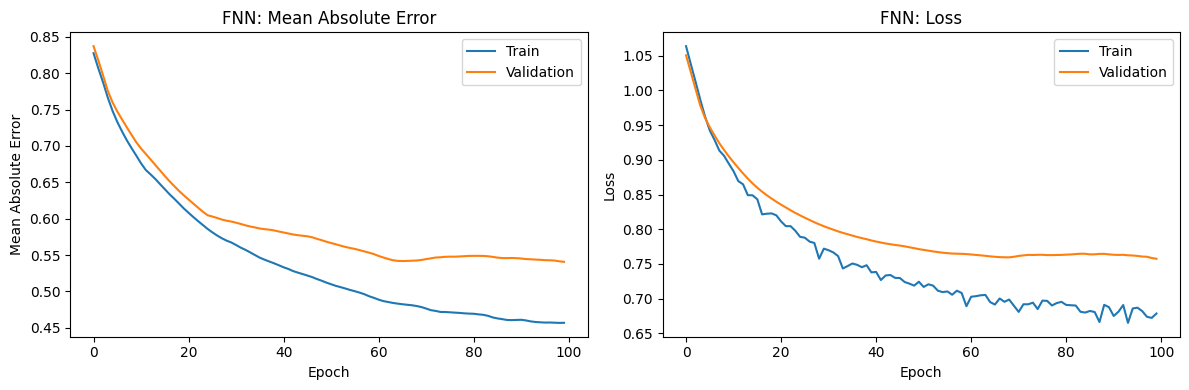

[04:17:46] ======== Monitor (0): HostSketchContainer ========
[04:17:46] AllReduce: 1e-05s, 1 calls @ 10us

[04:17:46] MakeCuts: 3e-05s, 1 calls @ 30us

[04:17:46] DEBUG: /workspace/src/gbm/gbtree.cc:130: Using tree method: 0
[04:17:46] DEBUG: /workspace/src/tree/updater_gpu_hist.cu:744: [GPU Hist]: Configure
[04:17:47] ======== Monitor (0):  ========
[04:17:47] InitCompressedData: 3.5e-05s, 1 calls @ 35us



/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


[04:17:47] ======== Monitor (0): Learner ========
[04:17:47] Configure: 1.02392s, 1 calls @ 1023917us

[04:17:47] EvalOneIter: 0.001004s, 250 calls @ 1004us

[04:17:47] GetGradient: 0.010665s, 250 calls @ 10665us

[04:17:47] PredictRaw: 0.000388s, 250 calls @ 388us

[04:17:47] UpdateOneIter: 1.59015s, 250 calls @ 1590146us

[04:17:47] ======== Monitor (0): GBTree ========
[04:17:47] BoostNewTrees: 0.551433s, 250 calls @ 551433us

[04:17:47] CommitModel: 0.000124s, 250 calls @ 124us

[04:17:47] ======== Device 0 Memory Allocations:  ========
[04:17:47] Peak memory usage: 32MiB
[04:17:47] Number of allocations: 22242
[04:17:47] ======== Monitor (0): updater_gpu_hist ========
[04:17:47] InitData: 0.000854s, 750 calls @ 854us

[04:17:47] InitDataOnce: 0.00071s, 1 calls @ 710us

[04:17:47] Update: 0.510568s, 750 calls @ 510568us

[04:17:47] UpdatePredictionCache: 0.020747s, 750 calls @ 20747us

[04:17:47] ======== Monitor (0): gradient_based_sampler ========
[04:17:47] Sample: 0.001891s, 75

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


3/3 [==============================] - 3s 273ms/step - loss: 1.2497 - mean_absolute_error: 0.9911 - mean_squared_error: 1.4478 - val_loss: 1.1928 - val_mean_absolute_error: 0.9710 - val_mean_squared_error: 1.3141
Epoch 2/100
3/3 [==============================] - 0s 17ms/step - loss: 1.2285 - mean_absolute_error: 0.9763 - mean_squared_error: 1.3995 - val_loss: 1.1743 - val_mean_absolute_error: 0.9588 - val_mean_squared_error: 1.2723
Epoch 3/100
3/3 [==============================] - 0s 16ms/step - loss: 1.2107 - mean_absolute_error: 0.9628 - mean_squared_error: 1.3567 - val_loss: 1.1564 - val_mean_absolute_error: 0.9467 - val_mean_squared_error: 1.2323
Epoch 4/100
3/3 [==============================] - 0s 17ms/step - loss: 1.1915 - mean_absolute_error: 0.9494 - mean_squared_error: 1.3154 - val_loss: 1.1392 - val_mean_absolute_error: 0.9351 - val_mean_squared_error: 1.1944
Epoch 5/100
3/3 [==============================] - 0s 17ms/step - loss: 1.1719 - mean_absolute_error: 0.9363 - mean

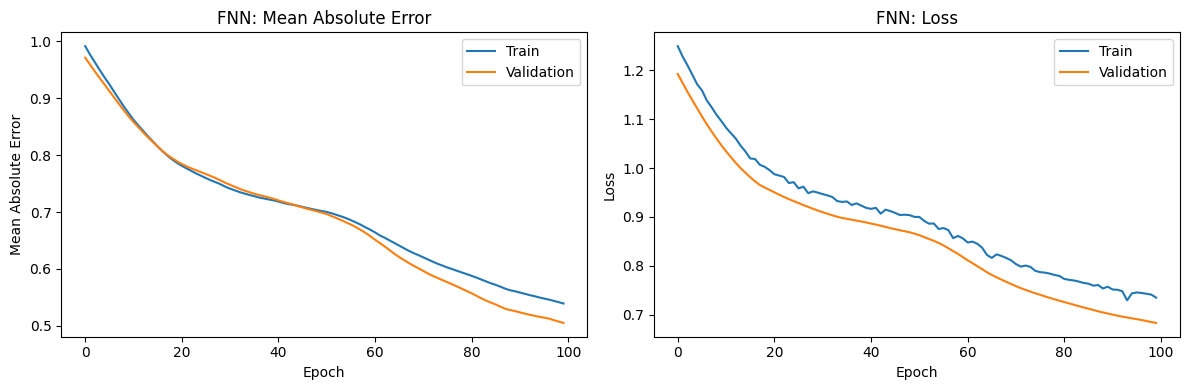

[04:18:33] ======== Monitor (0): HostSketchContainer ========
[04:18:33] AllReduce: 1e-05s, 1 calls @ 10us

[04:18:33] MakeCuts: 3.7e-05s, 1 calls @ 37us

[04:18:33] DEBUG: /workspace/src/gbm/gbtree.cc:130: Using tree method: 0
[04:18:33] DEBUG: /workspace/src/tree/updater_gpu_hist.cu:744: [GPU Hist]: Configure
[04:18:33] ======== Monitor (0):  ========
[04:18:33] InitCompressedData: 3.6e-05s, 1 calls @ 36us



/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


[04:18:33] ======== Monitor (0): Learner ========
[04:18:33] Configure: 0.000881s, 1 calls @ 881us

[04:18:33] EvalOneIter: 0.000949s, 250 calls @ 949us

[04:18:33] GetGradient: 0.010906s, 250 calls @ 10906us

[04:18:33] PredictRaw: 0.00025s, 250 calls @ 250us

[04:18:33] UpdateOneIter: 0.538519s, 250 calls @ 538519us

[04:18:33] ======== Monitor (0): GBTree ========
[04:18:33] BoostNewTrees: 0.523567s, 250 calls @ 523567us

[04:18:33] CommitModel: 0.000133s, 250 calls @ 133us

[04:18:33] ======== Device 0 Memory Allocations:  ========
[04:18:33] Peak memory usage: 32MiB
[04:18:33] Number of allocations: 42434
[04:18:33] ======== Monitor (0): updater_gpu_hist ========
[04:18:33] InitData: 0.000568s, 750 calls @ 568us

[04:18:33] InitDataOnce: 0.000439s, 1 calls @ 439us

[04:18:33] Update: 0.48278s, 750 calls @ 482780us

[04:18:33] UpdatePredictionCache: 0.020346s, 750 calls @ 20346us

[04:18:33] ======== Monitor (0): gradient_based_sampler ========
[04:18:33] Sample: 0.00122s, 750 call

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_10 (Dense)            (None, 128)               768       
                                                                 
 dense_11 (Dense)            (None, 64)                8256      
                                                                 
 dense_12 (Dense)            (None, 32)                2080      
                                                                 
 dense_13 (Dense)            (None, 16)                528       
                                                                 
 dense_14 (Dense)            (None, 3)                 51        
                                                                 
Total params: 11683 (45.64 KB)
Trainable params: 11683 (45.64 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/100
3/3 [=======================

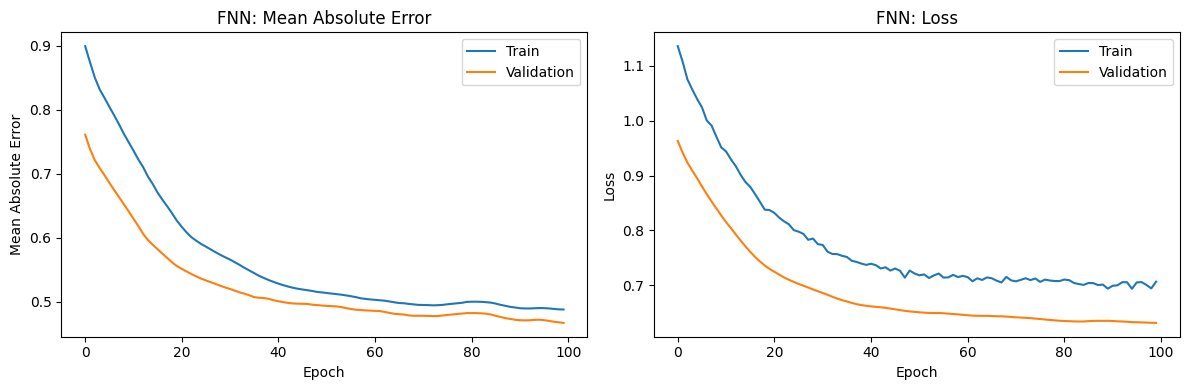

[04:18:50] ======== Monitor (0): HostSketchContainer ========
[04:18:50] AllReduce: 8e-06s, 1 calls @ 8us

[04:18:50] MakeCuts: 1.6e-05s, 1 calls @ 16us

[04:18:50] DEBUG: /workspace/src/gbm/gbtree.cc:130: Using tree method: 0
[04:18:50] DEBUG: /workspace/src/tree/updater_gpu_hist.cu:744: [GPU Hist]: Configure
[04:18:50] ======== Monitor (0):  ========
[04:18:50] InitCompressedData: 2.8e-05s, 1 calls @ 28us

[04:18:51] ======== Monitor (0): Learner ========
[04:18:51] Configure: 0.001265s, 1 calls @ 1265us

[04:18:51] EvalOneIter: 0.000983s, 250 calls @ 983us

[04:18:51] GetGradient: 0.010552s, 250 calls @ 10552us

[04:18:51] PredictRaw: 0.000229s, 250 calls @ 229us

[04:18:51] UpdateOneIter: 0.556728s, 250 calls @ 556728us

[04:18:51] ======== Monitor (0): GBTree ========
[04:18:51] BoostNewTrees: 0.541708s, 250 calls @ 541708us

[04:18:51] CommitModel: 0.00014s, 250 calls @ 140us

[04:18:51] ======== Device 0 Memory Allocations:  ========
[04:18:51] Peak memory usage: 32MiB
[04:18:51

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 1  | loss: 0.94583 | val_0_mae: 0.78787 |  0:00:00s
epoch 2  | loss: 0.9753  | val_0_mae: 0.78642 |  0:00:01s
epoch 3  | loss: 0.91581 | val_0_mae: 0.73003 |  0:00:01s
epoch 4  | loss: 0.81606 | val_0_mae: 0.71701 |  0:00:01s
epoch 5  | loss: 0.66493 | val_0_mae: 0.58919 |  0:00:02s
epoch 6  | loss: 0.73552 | val_0_mae: 0.67023 |  0:00:02s
epoch 7  | loss: 0.74152 | val_0_mae: 0.59149 |  0:00:02s
epoch 8  | loss: 0.63439 | val_0_mae: 0.59315 |  0:00:03s
epoch 9  | loss: 0.66541 | val_0_mae: 0.60563 |  0:00:03s
epoch 10 | loss: 0.63946 | val_0_mae: 0.62616 |  0:00:03s
epoch 11 | loss: 0.58628 | val_0_mae: 0.53817 |  0:00:04s
epoch 12 | loss: 0.7743  | val_0_mae: 0.62442 |  0:00:04s
epoch 13 | loss: 0.56381 | val_0_mae: 0.5135  |  0:00:04s
epoch 14 | loss: 0.64643 | val_0_mae: 0.58724 |  0:00:05s
epoch 15 | loss: 0.58902 | val_0_mae: 0.54123 |  0:00:05s
epoch 16 | loss: 0.72736 | val_0_mae: 0.5242  |  0:00:05s
epoch 17 | loss: 0.56334 | val_0_mae: 0.47263 |  0:00:06s
epoch 18 | los

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_15 (Dense)            (None, 128)               768       
                                                                 
 dense_16 (Dense)            (None, 64)                8256      
                                                                 
 dense_17 (Dense)            (None, 32)                2080      
                                                                 
 dense_18 (Dense)            (None, 16)                528       
                                                                 
 dense_19 (Dense)            (None, 3)                 51        
                                                                 
Total params: 11683 (45.64 KB)
Trainable params: 11683 (45.64 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/100
3/3 [=

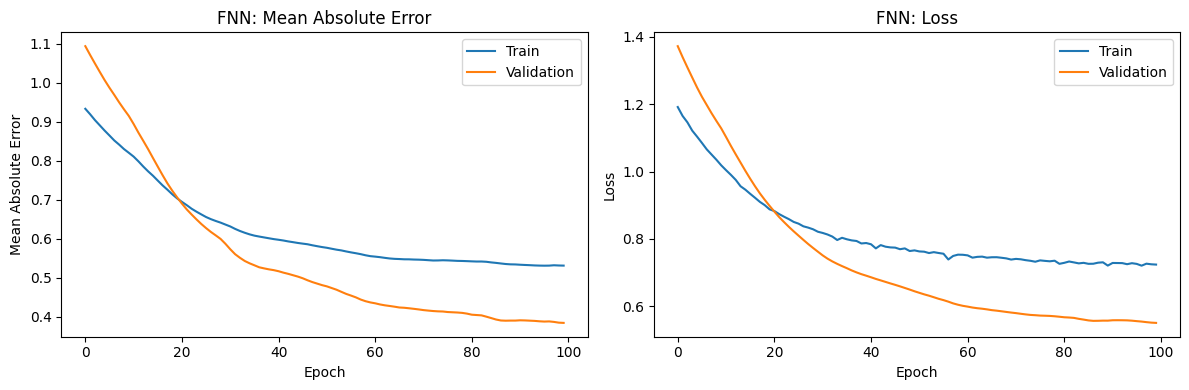

[04:19:13] ======== Monitor (0): HostSketchContainer ========
[04:19:13] AllReduce: 9e-06s, 1 calls @ 9us

[04:19:13] MakeCuts: 1.6e-05s, 1 calls @ 16us

[04:19:13] DEBUG: /workspace/src/gbm/gbtree.cc:130: Using tree method: 0
[04:19:13] DEBUG: /workspace/src/tree/updater_gpu_hist.cu:744: [GPU Hist]: Configure
[04:19:13] ======== Monitor (0):  ========
[04:19:13] InitCompressedData: 4.7e-05s, 1 calls @ 47us

[04:19:13] ======== Monitor (0): Learner ========
[04:19:13] Configure: 0.001002s, 1 calls @ 1002us

[04:19:13] EvalOneIter: 0.001029s, 250 calls @ 1029us

[04:19:13] GetGradient: 0.010999s, 250 calls @ 10999us

[04:19:13] PredictRaw: 0.000266s, 250 calls @ 266us

[04:19:13] UpdateOneIter: 0.543886s, 250 calls @ 543886us

[04:19:13] ======== Monitor (0): GBTree ========
[04:19:13] BoostNewTrees: 0.528511s, 250 calls @ 528511us

[04:19:13] CommitModel: 0.000133s, 250 calls @ 133us

[04:19:13] ======== Device 0 Memory Allocations:  ========
[04:19:13] Peak memory usage: 32MiB
[04:19:

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.60262 | val_0_mae: 0.79175 |  0:00:00s
epoch 1  | loss: 1.08119 | val_0_mae: 1.00022 |  0:00:00s
epoch 2  | loss: 0.7573  | val_0_mae: 0.83564 |  0:00:01s
epoch 3  | loss: 0.98281 | val_0_mae: 0.94449 |  0:00:01s
epoch 4  | loss: 0.58328 | val_0_mae: 0.60352 |  0:00:01s
epoch 5  | loss: 0.67253 | val_0_mae: 0.66615 |  0:00:02s
epoch 6  | loss: 0.68889 | val_0_mae: 0.66751 |  0:00:02s
epoch 7  | loss: 0.60202 | val_0_mae: 0.64824 |  0:00:02s
epoch 8  | loss: 0.58469 | val_0_mae: 0.63539 |  0:00:03s
epoch 9  | loss: 0.71886 | val_0_mae: 0.53986 |  0:00:03s
epoch 10 | loss: 0.63993 | val_0_mae: 0.53581 |  0:00:03s
epoch 11 | loss: 0.63961 | val_0_mae: 0.60621 |  0:00:04s
epoch 12 | loss: 0.65532 | val_0_mae: 0.61752 |  0:00:04s
epoch 13 | loss: 0.73458 | val_0_mae: 0.71022 |  0:00:04s
epoch 14 | loss: 0.58038 | val_0_mae: 0.56595 |  0:00:05s
epoch 15 | loss: 0.66748 | val_0_mae: 0.62561 |  0:00:05s
epoch 16 | loss: 0.58001 | val_0_mae: 0.51415 |  0:00:05s
epoch 17 | los

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_20 (Dense)            (None, 128)               768       
                                                                 
 dense_21 (Dense)            (None, 64)                8256      
                                                                 
 dense_22 (Dense)            (None, 32)                2080      
                                                                 
 dense_23 (Dense)            (None, 16)                528       
                                                                 
 dense_24 (Dense)            (None, 3)                 51        
                                                                 
Total params: 11683 (45.64 KB)
Trainable params: 11683 (45.64 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/100
3/3 [=======================

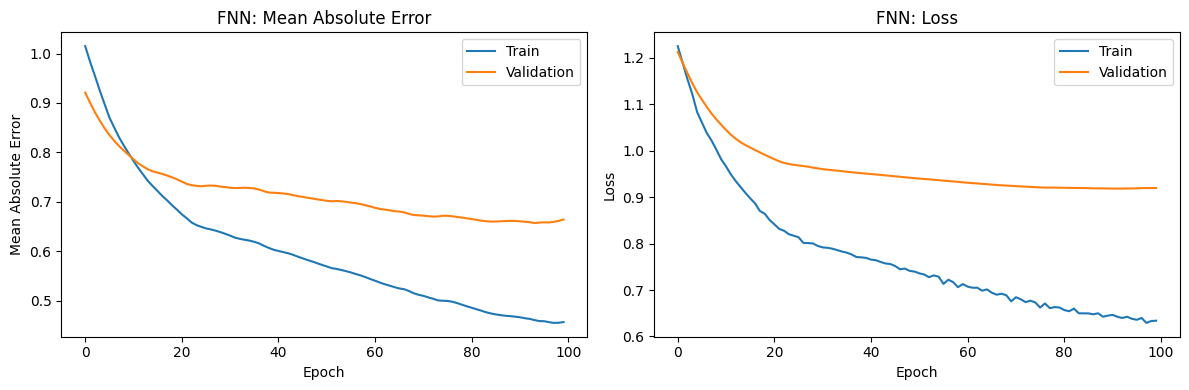

[04:19:34] ======== Monitor (0): HostSketchContainer ========
[04:19:34] AllReduce: 8e-06s, 1 calls @ 8us

[04:19:34] MakeCuts: 1.6e-05s, 1 calls @ 16us

[04:19:34] DEBUG: /workspace/src/gbm/gbtree.cc:130: Using tree method: 0
[04:19:34] DEBUG: /workspace/src/tree/updater_gpu_hist.cu:744: [GPU Hist]: Configure
[04:19:34] ======== Monitor (0):  ========
[04:19:34] InitCompressedData: 2.7e-05s, 1 calls @ 27us

[04:19:34] ======== Monitor (0): Learner ========
[04:19:34] Configure: 0.000924s, 1 calls @ 924us

[04:19:34] EvalOneIter: 0.000996s, 250 calls @ 996us

[04:19:34] GetGradient: 0.011188s, 250 calls @ 11188us

[04:19:34] PredictRaw: 0.000238s, 250 calls @ 238us

[04:19:34] UpdateOneIter: 0.551967s, 250 calls @ 551967us

[04:19:34] ======== Monitor (0): GBTree ========
[04:19:34] BoostNewTrees: 0.536617s, 250 calls @ 536617us

[04:19:34] CommitModel: 0.000116s, 250 calls @ 116us

[04:19:34] ======== Device 0 Memory Allocations:  ========
[04:19:34] Peak memory usage: 32MiB
[04:19:34

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.72645 | val_0_mae: 0.79516 |  0:00:00s
epoch 1  | loss: 0.72059 | val_0_mae: 0.82508 |  0:00:00s
epoch 2  | loss: 0.83562 | val_0_mae: 1.00482 |  0:00:01s
epoch 3  | loss: 0.55462 | val_0_mae: 0.72465 |  0:00:01s
epoch 4  | loss: 0.6865  | val_0_mae: 0.68314 |  0:00:01s
epoch 5  | loss: 0.69882 | val_0_mae: 0.7052  |  0:00:02s
epoch 6  | loss: 0.5367  | val_0_mae: 0.72653 |  0:00:02s
epoch 7  | loss: 0.65379 | val_0_mae: 0.71056 |  0:00:02s
epoch 8  | loss: 0.61283 | val_0_mae: 0.67245 |  0:00:03s
epoch 9  | loss: 0.48039 | val_0_mae: 0.67837 |  0:00:03s
epoch 10 | loss: 0.62381 | val_0_mae: 0.6821  |  0:00:03s
epoch 11 | loss: 0.5902  | val_0_mae: 0.68869 |  0:00:04s
epoch 12 | loss: 0.64274 | val_0_mae: 0.70711 |  0:00:04s
epoch 13 | loss: 0.4952  | val_0_mae: 0.69649 |  0:00:04s
epoch 14 | loss: 0.58916 | val_0_mae: 0.683   |  0:00:05s
epoch 15 | loss: 0.64275 | val_0_mae: 0.68424 |  0:00:05s
epoch 16 | loss: 0.45471 | val_0_mae: 0.65235 |  0:00:05s
epoch 17 | los

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


In [ ]:
# Call train models function on each k fold
model_dictionary = dict()
for i in range(index+1):
  X_train_index = X_train_indices[i]
  X_val_index = X_val_indices[i]
  X_test_index = X_test_indices[i]
  X_train = X_selected[X_train_index]
  y_train = y_selected[X_train_index]
  X_val = X_selected[X_val_index]
  y_val = y_selected[X_val_index]
  X_test = X_selected[X_test_index]
  y_test = y_selected[X_test_index]
  X_train = X_train.astype(float)
  y_train = y_train.astype(float)
  X_val = X_val.astype(float)
  y_val = y_val.astype(float)
  X_test = X_test.astype(float)
  y_test = y_test.astype(float)

  nn_model, xgb_model, tabnet_model = train_models(X_train,y_train,X_val,y_val)
  model_dictionary[i] = [nn_model,xgb_model,tabnet_model]


# EVALUATION

In [ ]:
# Evaluation tables
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
names = ["Width","Length","Input Impedance"]
model_names = ["FNN","XGBoost","TabNet"]
num_models = len(model_dictionary)
num_targets = 3
y_pred_models = [[] for _ in range(num_models)]
y_test_targets = [[] for _ in range(num_targets)]
for i in range(num_models):
    nn_model, xgb_model, tabnet_model = model_dictionary[i]
    y_pred_nn = bc.inverse_transform(nn_model.predict(X_test))
    y_pred_xgb = bc.inverse_transform(xgb_model.predict(X_test))
    y_pred_tab = bc.inverse_transform(tabnet_model.predict(X_test))
    y_pred_models[i] = [y_pred_nn, y_pred_xgb, y_pred_tab]
    inverse_y = bc.inverse_transform(y_test)
    y_test_targets[0] = inverse_y[:, 0]
    y_test_targets[1] = inverse_y[:, 1]
    y_test_targets[2] = inverse_y[:, 2]

for t in range(num_targets):
    metrics_data = []
    y_test_target = y_test_targets[t]
    target_data = {
        "Target": names[t]
    }
    for model_type in range(len(y_pred_models[0])):
        mean = np.zeros_like(y_pred_models[0][model_type][:, t])
        squared_diff_sum = np.zeros_like(y_pred_models[0][model_type][:, t])
        for k_fold in range(len(y_pred_models)):
            y_pred_fold = y_pred_models[k_fold][model_type][:, t]
            mean += y_pred_fold
            squared_diff_sum += (y_pred_fold - mean) ** 2
        mean = mean / len(y_pred_models)
        std_deviation = np.sqrt(squared_diff_sum / len(y_pred_models))
        mse = mean_squared_error(y_test_target, mean)
        mae = mean_absolute_error(y_test_target, mean)
        rmse = np.sqrt(mse)
        r_squared = r2_score(y_test_target, mean)
        target_data[f"Mean ({model_names[model_type]})"] = mean
        target_data[f"SD ({model_names[model_type]})"] = std_deviation
        target_data[f"MSE ({model_names[model_type]})"] = mse
        target_data[f"MAE ({model_names[model_type]})"] = mae
        target_data[f"RMSE ({model_names[model_type]})"] = rmse
        target_data[f"R² ({model_names[model_type]})"] = r_squared

    metrics_data.append(target_data)
    metrics_df = pd.DataFrame(metrics_data)
    display(metrics_df)

1/1 [==============================] - 0s 83ms/step
[04:19:54] DEBUG: /workspace/src/gbm/gbtree.cc:130: Using tree method: 0
[04:19:54] DEBUG: /workspace/src/tree/updater_gpu_hist.cu:744: [GPU Hist]: Configure
1/1 [==============================] - 4s 4s/step
[04:20:04] DEBUG: /workspace/src/gbm/gbtree.cc:130: Using tree method: 0
[04:20:04] DEBUG: /workspace/src/tree/updater_gpu_hist.cu:744: [GPU Hist]: Configure
1/1 [==============================] - 10s 10s/step
[04:20:25] DEBUG: /workspace/src/gbm/gbtree.cc:130: Using tree method: 0
[04:20:25] DEBUG: /workspace/src/tree/updater_gpu_hist.cu:744: [GPU Hist]: Configure


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but PowerTransformer was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but PowerTransformer was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but PowerTransformer was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but PowerTransformer was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but PowerTransformer was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature n

1/1 [==============================] - 10s 10s/step


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but PowerTransformer was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but PowerTransformer was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but PowerTransformer was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but PowerTransformer was fitted with feature names
  warnings.warn(


[04:20:45] DEBUG: /workspace/src/gbm/gbtree.cc:130: Using tree method: 0
[04:20:45] DEBUG: /workspace/src/tree/updater_gpu_hist.cu:744: [GPU Hist]: Configure
1/1 [==============================] - 20s 20s/step
[04:21:06] DEBUG: /workspace/src/gbm/gbtree.cc:130: Using tree method: 0
[04:21:06] DEBUG: /workspace/src/tree/updater_gpu_hist.cu:744: [GPU Hist]: Configure


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but PowerTransformer was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but PowerTransformer was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but PowerTransformer was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but PowerTransformer was fitted with feature names
  warnings.warn(


,Target,Mean (FNN),SD (FNN),MSE (FNN),MAE (FNN),RMSE (FNN),R² (FNN),Mean (XGBoost),SD (XGBoost),MSE (XGBoost),MAE (XGBoost),RMSE (XGBoost),R² (XGBoost),Mean (TabNet),SD (TabNet),MSE (TabNet),MAE (TabNet),RMSE (TabNet),R² (TabNet)
0,Width,"[-26.49589, -15.522408, -21.174337, -21.136349...","[64.92175, 36.58352, 51.46837, 51.371857, 61.9...",2.599264,1.510528,1.612223,0.824256,"[-29.182755, -17.34699, -20.083733, -20.03529,...","[71.49005, 42.52244, 49.19087, 49.065273, 57.6...",0.110543,0.217844,0.332481,0.992526,"[-26.112635, -17.71979, -21.660616, -21.609987...","[63.76471, 43.614388, 52.85961, 52.71936, 61.2...",3.617778,1.752305,1.902046,0.755391


,Target,Mean (FNN),SD (FNN),MSE (FNN),MAE (FNN),RMSE (FNN),R² (FNN),Mean (XGBoost),SD (XGBoost),MSE (XGBoost),MAE (XGBoost),RMSE (XGBoost),R² (XGBoost),Mean (TabNet),SD (TabNet),MSE (TabNet),MAE (TabNet),RMSE (TabNet),R² (TabNet)
0,Length,"[17.10374, 50.747543, 34.948376, 35.068703, 21...","[42.974766, 123.63486, 85.35108, 85.63103, 56....",30.864505,5.17547,5.555583,0.81638,"[6.5285354, 46.35509, 38.836708, 38.982323, 25...","[15.967873, 113.46954, 95.14234, 95.521255, 67...",1.455065,0.769523,1.206261,0.991343,"[18.41203, 47.398903, 33.822662, 33.999825, 22...","[46.08729, 115.34113, 83.33692, 83.8048, 55.28...",42.287267,5.969874,6.502866,0.748423


,Target,Mean (FNN),SD (FNN),MSE (FNN),MAE (FNN),RMSE (FNN),R² (FNN),Mean (XGBoost),SD (XGBoost),MSE (XGBoost),MAE (XGBoost),RMSE (XGBoost),R² (XGBoost),Mean (TabNet),SD (TabNet),MSE (TabNet),MAE (TabNet),RMSE (TabNet),R² (TabNet)
0,Input Impedance,"[37.091698, 64.06679, 50.746727, 50.870068, 37...","[90.97984, 158.11179, 124.6515, 124.957405, 93...",382.032949,13.980834,19.545663,0.268273,"[83.88673, 66.258644, 59.25464, 59.385193, 24....","[205.25264, 162.09581, 145.14421, 145.36258, 5...",1.905511,0.985845,1.380402,0.99635,"[38.127155, 63.23236, 50.122753, 50.31383, 38....","[95.58347, 154.56921, 124.50032, 124.989334, 9...",386.552263,14.564902,19.660932,0.259617


1/1 [==============================] - 10s 10s/step


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but PowerTransformer was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but PowerTransformer was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but PowerTransformer was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but PowerTransformer was fitted with feature names
  warnings.warn(


1/1 [==============================] - 10s 10s/step


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but PowerTransformer was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but PowerTransformer was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but PowerTransformer was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but PowerTransformer was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but PowerTransformer was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature n

1/1 [==============================] - 0s 21ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but PowerTransformer was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but PowerTransformer was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but PowerTransformer was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but PowerTransformer was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but PowerTransformer was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature n

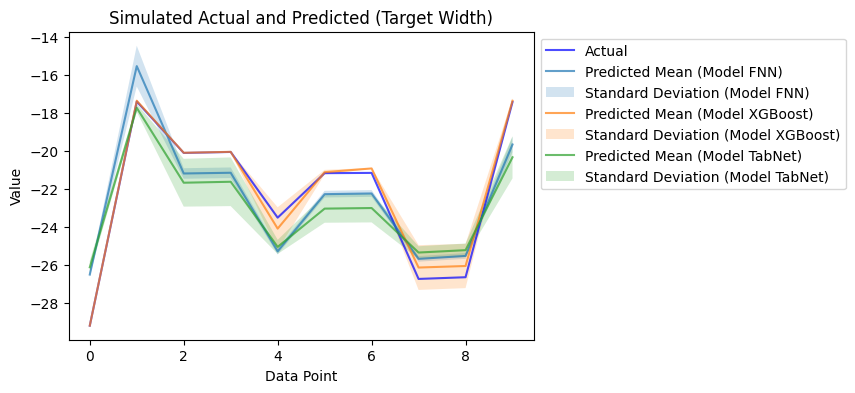

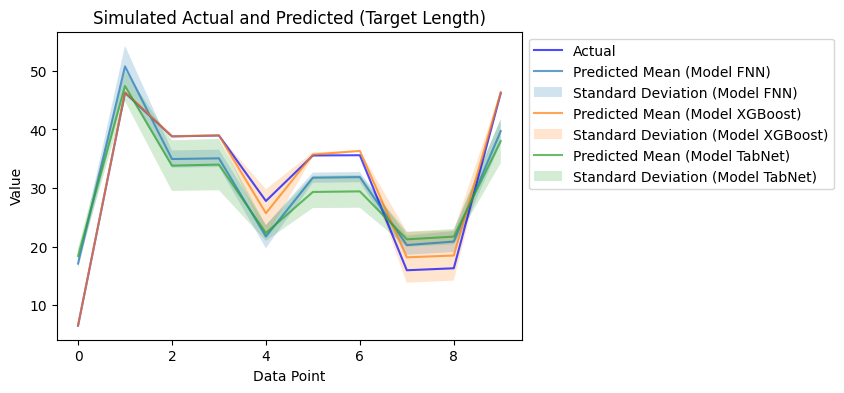

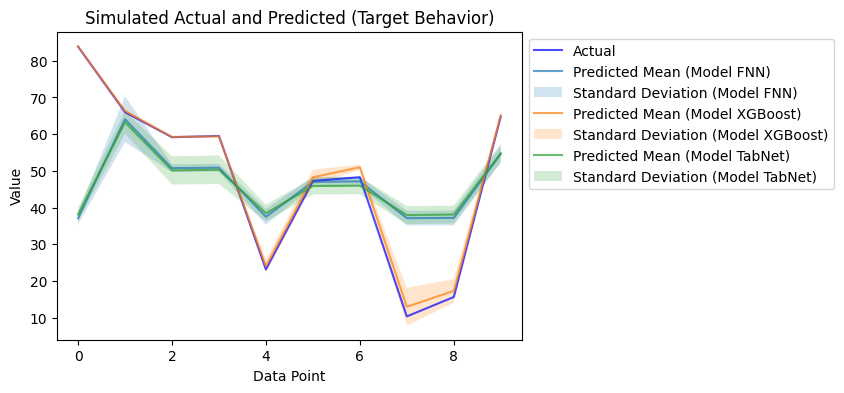

In [ ]:
# Evaluation plots
names = ["Width","Length","Behavior"]
model_names = ["FNN","XGBoost","TabNet"]
num_models = len(model_dictionary)
num_targets = 3
y_pred_models = [[] for _ in range(num_models)]
y_test_targets = [[] for _ in range(num_targets)]
for i in range(num_models):
    nn_model, xgb_model, tabnet_model = model_dictionary[i]
    y_pred_nn = bc.inverse_transform(nn_model.predict(X_test))
    y_pred_xgb = bc.inverse_transform(xgb_model.predict(X_test))
    y_pred_tab = bc.inverse_transform(tabnet_model.predict(X_test))
    y_pred_models[i] = [y_pred_nn, y_pred_xgb, y_pred_tab]
    inverse_y = bc.inverse_transform(y_test)
    y_test_targets[0] = inverse_y[:, 0]
    y_test_targets[1] = inverse_y[:, 1]
    y_test_targets[2] = inverse_y[:, 2]
for t in range(num_targets):
  y_test_target = y_test_targets[t]
  plt.figure(figsize=(6, 4))
  plt.plot(range(len(y_test_target)), y_test_target, label='Actual', color='blue', alpha=0.7)
  for model_type in range(len(y_pred_models[0])):
    mean = np.zeros_like(y_pred_models[0][model_type][:, t])
    squared_diff_sum = np.zeros_like(y_pred_models[0][model_type][:, t])
    for k_fold in range(len(y_pred_models)):
      y_pred_fold = y_pred_models[k_fold][model_type][:, t]
      mean += y_pred_fold
    mean = mean / len(y_pred_models)
    for k_fold in range(len(y_pred_models)):
      y_pred_fold = y_pred_models[k_fold][model_type][:, t]
      squared_diff_sum += (y_pred_fold - mean) ** 2
    std_deviation = np.sqrt(squared_diff_sum / len(y_pred_models))
    std_deviation = np.sqrt(squared_diff_sum / len(y_pred_models))
    plt.plot(range(len(y_test_target)), mean, label=f'Predicted Mean (Model {model_names[model_type]})', alpha=0.7)
    plt.fill_between(range(len(y_test_target)), mean - std_deviation, mean + std_deviation, alpha=0.2, label=f'Standard Deviation (Model {model_names[model_type]})')
  plt.title(f'Simulated Actual and Predicted (Target {names[t]})')
  plt.xlabel('Data Point')
  plt.ylabel('Value')
  plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
  plt.show()